In [ ]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer

import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
def check_missing_col(df):
    missing_col = []
    for col in df.columns:
        missing_values = sum(df[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다')
            missing_col.append([col, df[col].dtype])
        if missing_col == []:
            print('결측치가 존재하지 않습니다')
        return missing_col

In [ ]:
def clean_text(texts):
    corpus = []
    for i in range(len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','', review)#숫자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        corpus.append(review) 
    return corpus

In [ ]:
stopwords_list = stopwords.words('english')
wlem = nltk.WordNetLemmatizer()

In [ ]:
train['text'] = clean_text(train['text'])
test['text'] = clean_text(test['text'])

In [ ]:
train['tokenized'] = train['text'].apply(nltk.word_tokenize)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [ ]:
test['tokenized'] = test['text'].apply(nltk.word_tokenize)
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [ ]:
# from sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(train, test_size=0.25, random_state=42)
# print("훈련용 리뷰의 개수 : ", len(train_data))
# print("테스트용 리뷰의 개수 : ", len(test_data))

훈련용 리뷰의 개수 :  6924
테스트용 리뷰의 개수 :  2309


In [ ]:
X_train = train['tokenized'].values
y_train = train['target'].values
X_test = test['tokenized'].values

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if (value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크키 : ", total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수: %s"%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율: ", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: ", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크키 :  139348
등장 빈도가 1번 이하인 희귀 단어의 수: 99116
단어 집합에서 희귀 단어의 비율:  71.12839796767804
전체 등장 빈도에서 희귀 단어 등장 빈도 비율:  11.066722344917835


In [ ]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  40234


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 7025
리뷰의 평균 길이 : 97.00227445034116


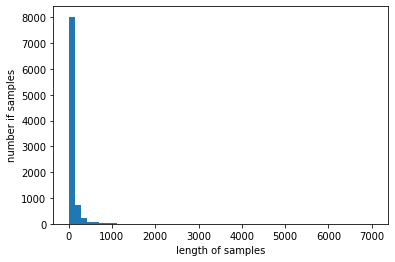

In [ ]:
# 패딩
print('리뷰의 최대 길이 :', max(len(words) for words in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number if samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 1000
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 1000 이하인 샘플의 비율: 99.01440485216074


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
onehot_Y_train = np_utils.to_categorical(y_train)

In [ ]:
# vocab_size = 2000
embedding_dim = 100
# max_length = 1000
# padding_type='post'

In [ ]:
model = Sequential([Embedding(vocab_size, embedding_dim, input_length=max_len),
                     tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
                     tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
                     tf.keras.layers.Bidirectional(LSTM(units=64)),
                     Dense(20, activation='softmax')]) # 결과값이 0~19 이므로 Dense(20)
model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         4023400   
                                                                 
 bidirectional_6 (Bidirectio  (None, 1000, 128)        84480     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 1000, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                      

In [ ]:
# 모델 실행
history = model.fit(X_train, onehot_Y_train, epochs=50, batch_size=100, validation_split=0.2)

Epoch 1/50
74/74 [==============================] - 32s 325ms/step - loss: 2.8004 - accuracy: 0.0960 - val_loss: 2.4945 - val_accuracy: 0.1684
Epoch 2/50
74/74 [==============================] - 22s 298ms/step - loss: 2.1842 - accuracy: 0.2465 - val_loss: 2.2054 - val_accuracy: 0.2512
Epoch 3/50
74/74 [==============================] - 22s 300ms/step - loss: 1.7299 - accuracy: 0.3855 - val_loss: 2.0633 - val_accuracy: 0.3021
Epoch 4/50
74/74 [==============================] - 22s 299ms/step - loss: 1.3869 - accuracy: 0.5081 - val_loss: 2.0395 - val_accuracy: 0.3492
Epoch 5/50
74/74 [==============================] - 22s 301ms/step - loss: 1.1212 - accuracy: 0.6064 - val_loss: 2.0538 - val_accuracy: 0.3671
Epoch 6/50
74/74 [==============================] - 22s 301ms/step - loss: 0.9530 - accuracy: 0.6787 - val_loss: 2.0860 - val_accuracy: 0.3828
Epoch 7/50
74/74 [==============================] - 22s 304ms/step - loss: 0.7872 - accuracy: 0.7285 - val_loss: 2.1324 - val_accuracy: 0.3898

In [ ]:
len(X_train)

6924

In [ ]:
pad_test = pad_sequences(test, maxlen=max_len)

ValueError: ignored

In [ ]:
test_pred = model.predict(pad_test)

In [ ]:
test_pred.to_csv('test_pred.csv', index=False)

<function matplotlib.pyplot.show>

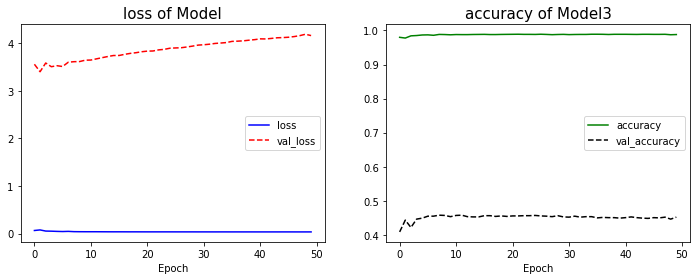

In [ ]:
# 학습 결과 확인
plt.figure(figsize=(12,4))
plt.title('Model', fontsize=15)

plt.subplot(1, 2, 1)
plt.title('loss of Model', fontsize=15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Model3', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [ ]:
model = Sequential([Embedding(vocab_size, embedding_dim, input_length=max_len),
                     tf.keras.layers.Bidirectional(LSTM(units=128, return_sequences=True)),
                     tf.keras.layers.Bidirectional(LSTM(units=128, return_sequences=True)),
                     tf.keras.layers.Bidirectional(LSTM(units=128)),
                     Dense(20, activation='softmax')]) # 결과값이 0~19 이므로 Dense(20)
model.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         3199800   
                                                                 
 bidirectional_3 (Bidirectio  (None, 1000, 256)        234496    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 1000, 256)        394240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 20)                5140      
                                                      

In [ ]:
# 모델 실행
history = model.fit(X_train, onehot_Y_train, epochs=50, batch_size=100, validation_split=0.2)

Epoch 1/50
56/56 [==============================] - 37s 507ms/step - loss: 0.2460 - accuracy: 0.0536 - val_loss: 0.1994 - val_accuracy: 0.0498
Epoch 2/50
56/56 [==============================] - 27s 476ms/step - loss: 0.1995 - accuracy: 0.0478 - val_loss: 0.1990 - val_accuracy: 0.0635
Epoch 3/50
56/56 [==============================] - 27s 478ms/step - loss: 0.1993 - accuracy: 0.0489 - val_loss: 0.1993 - val_accuracy: 0.0469
Epoch 4/50
56/56 [==============================] - 27s 477ms/step - loss: 0.1990 - accuracy: 0.0507 - val_loss: 0.1996 - val_accuracy: 0.0448
Epoch 5/50
56/56 [==============================] - 27s 478ms/step - loss: 0.1992 - accuracy: 0.0538 - val_loss: 0.1993 - val_accuracy: 0.0448
Epoch 6/50
56/56 [==============================] - 27s 477ms/step - loss: 0.1992 - accuracy: 0.0518 - val_loss: 0.1995 - val_accuracy: 0.0527
Epoch 7/50
56/56 [==============================] - 27s 478ms/step - loss: 0.1994 - accuracy: 0.0491 - val_loss: 0.1997 - val_accuracy: 0.0527

KeyboardInterrupt: ignored

In [ ]:
def plot_doc_lengths(df):
  mean_seq_len = np.round(df['doc_len'].mean()).astype(int)
  sns.distplot(tuple(df['doc_len']), hist=True, kde=True, label='lengths')
  plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'mean:{mean_seq_len}')
  plt.title('lengths')
  plt.legend()
  plt.show()
  print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어")

In [ ]:
train_data['doc_len'] = train_data['text'].apply(lambda x:len(x.split()))
plot_doc_lengths(train_data)

In [ ]:
train_data['doc_len'] = train_data['text'].apply(lambda x:len(x.split()))

In [ ]:
train_data

In [ ]:
plot_doc_lengths(train_data)